In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
%cd /gdrive/My Drive/ANN2DL/homework1

/gdrive/My Drive/ANN2DL/homework1


In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfkl = tf.keras.layers
tfk = tf.keras

In [6]:
seed = 42
random.seed(seed)

In [7]:
processed_data = np.load('processed_data.npz')
X = processed_data['X']
y = processed_data['y']
labels = {0:'healthy', 1:'unhealthy'}

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    stratify=y_train_val,
    random_state=seed
)

# Print the shapes of the resulting datasets
print("Training_Validation Data Shape:", X_train_val.shape)
print("Training_Validation Label Shape:", y_train_val.shape)
print("Train Data Shape:", X_train.shape)
print("Train Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training_Validation Data Shape: (4503, 96, 96, 3)
Training_Validation Label Shape: (4503, 2)
Train Data Shape: (4002, 96, 96, 3)
Train Label Shape: (4002, 2)
Validation Data Shape: (501, 96, 96, 3)
Validation Label Shape: (501, 2)
Test Data Shape: (501, 96, 96, 3)
Test Label Shape: (501, 2)


In [8]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of y_train classes:')
print(pd.DataFrame(np.argmax(y_train, axis=-1), columns=['class']).value_counts())

print('Counting occurrences of y_val classes:')
print(pd.DataFrame(np.argmax(y_val, axis=-1), columns=['class']).value_counts())

print('Counting occurrences of y_test classes:')
print(pd.DataFrame(np.argmax(y_val, axis=-1), columns=['class']).value_counts())

Counting occurrences of y_train classes:
class
0        2480
1        1522
dtype: int64
Counting occurrences of y_val classes:
class
0        311
1        190
dtype: int64
Counting occurrences of y_test classes:
class
0        311
1        190
dtype: int64


In [ ]:
dataset_dir = 'cleaned_dataset'
dataset_images = np.load(f'{dataset_dir}/cleaned_data_images.npy', allow_pickle=True)
dataset_labels = np.load(f'{dataset_dir}/cleaned_data_labels.npy', allow_pickle=True)

In [ ]:
def custom_label_encoder(data, encoding_preferences):
    encoded_data = np.array([encoding_preferences.get(val, -1) for val in data])
    return encoded_data

encoding = {
    'healthy': 0,
    'unhealthy': 1,
}
y = custom_label_encoder(dataset_labels, encoding)

print(f'Dataset Labels Shape {y.shape}')
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(dataset_labels, columns=['class'])['class'].value_counts())

In [ ]:
dataset_images_norm = (dataset_images / 255).astype('float32')
print(f'Dataset Data Shape {dataset_images_norm.shape}')

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    dataset_images_norm,
    y,
    test_size=0.1,
    stratify=y
)
# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    stratify=y_train_val
)

In [9]:
dataset_img_size = (96, 96)
dataset_img_shape = (96, 96, 3)

In [10]:
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
]

input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = 1  # Output shape for the model

In [ ]:
def conv_parallel_block(x,filters,kernel_size,dense,padding = 'same', activation='relu',parallel=3):

    x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name=f'Conv_{dense}_1')(x)
    x_ = tfkl.BatchNormalization(name=f'BatchNorm_{dense}')(x_)
    x_ = tfkl.Activation(activation, name=f'Activation{dense}')(x_)
    x_ = tfkl.Dropout(0.3, seed=seed)(x_)
    x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name=f'Conv_{dense}_1_2')(x_)
    x_ = tfkl.GlobalAveragePooling2D()(x_)

    return x_

In [ ]:
def build_Parallel_CNN(input_shape=input_shape,output_shape=output_shape, learning_rate=1e-4, seed=seed):

  tf.random.set_seed(seed)
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Initial convolution with batch normalization and activation
  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(input_layer)
  x = tfkl.BatchNormalization(name='BatchNorm0')(x)
  x = tfkl.Activation('relu', name='ReLU0')(x)

  parallel_CNN1 = conv_parallel_block(x,16,3,1)
  parallel_CNN2 = conv_parallel_block(x,32,5,2)
  parallel_CNN3 = conv_parallel_block(x,64,3,3)

  concatenated = tfkl.Concatenate()([parallel_CNN1,parallel_CNN2,parallel_CNN3])
  x = tfkl.Dense(output_shape, name='Dense')(concatenated)
  output_activation = tfkl.Activation('sigmoid', name='Sigmoid')(x)

  # Create the model
  model = tfk.Model(inputs=input_layer, outputs=output_activation, name='Parallel_CNN')
  optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
  loss = tfk.losses.BinaryCrossentropy()
  metrics = ['accuracy']

  # Compile the model
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

Model: "Parallel_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv0 (Conv2D)                 (None, 96, 96, 64)   1792        ['Input[0][0]']                  
                                                                                                  
 BatchNorm0 (BatchNormalization  (None, 96, 96, 64)  256         ['Conv0[0][0]']                  
 )                                                                                                
                                                                                                  
 ReLU0 (Activation)             (None, 96, 96, 64)   0           ['BatchNorm0[0][0]']  

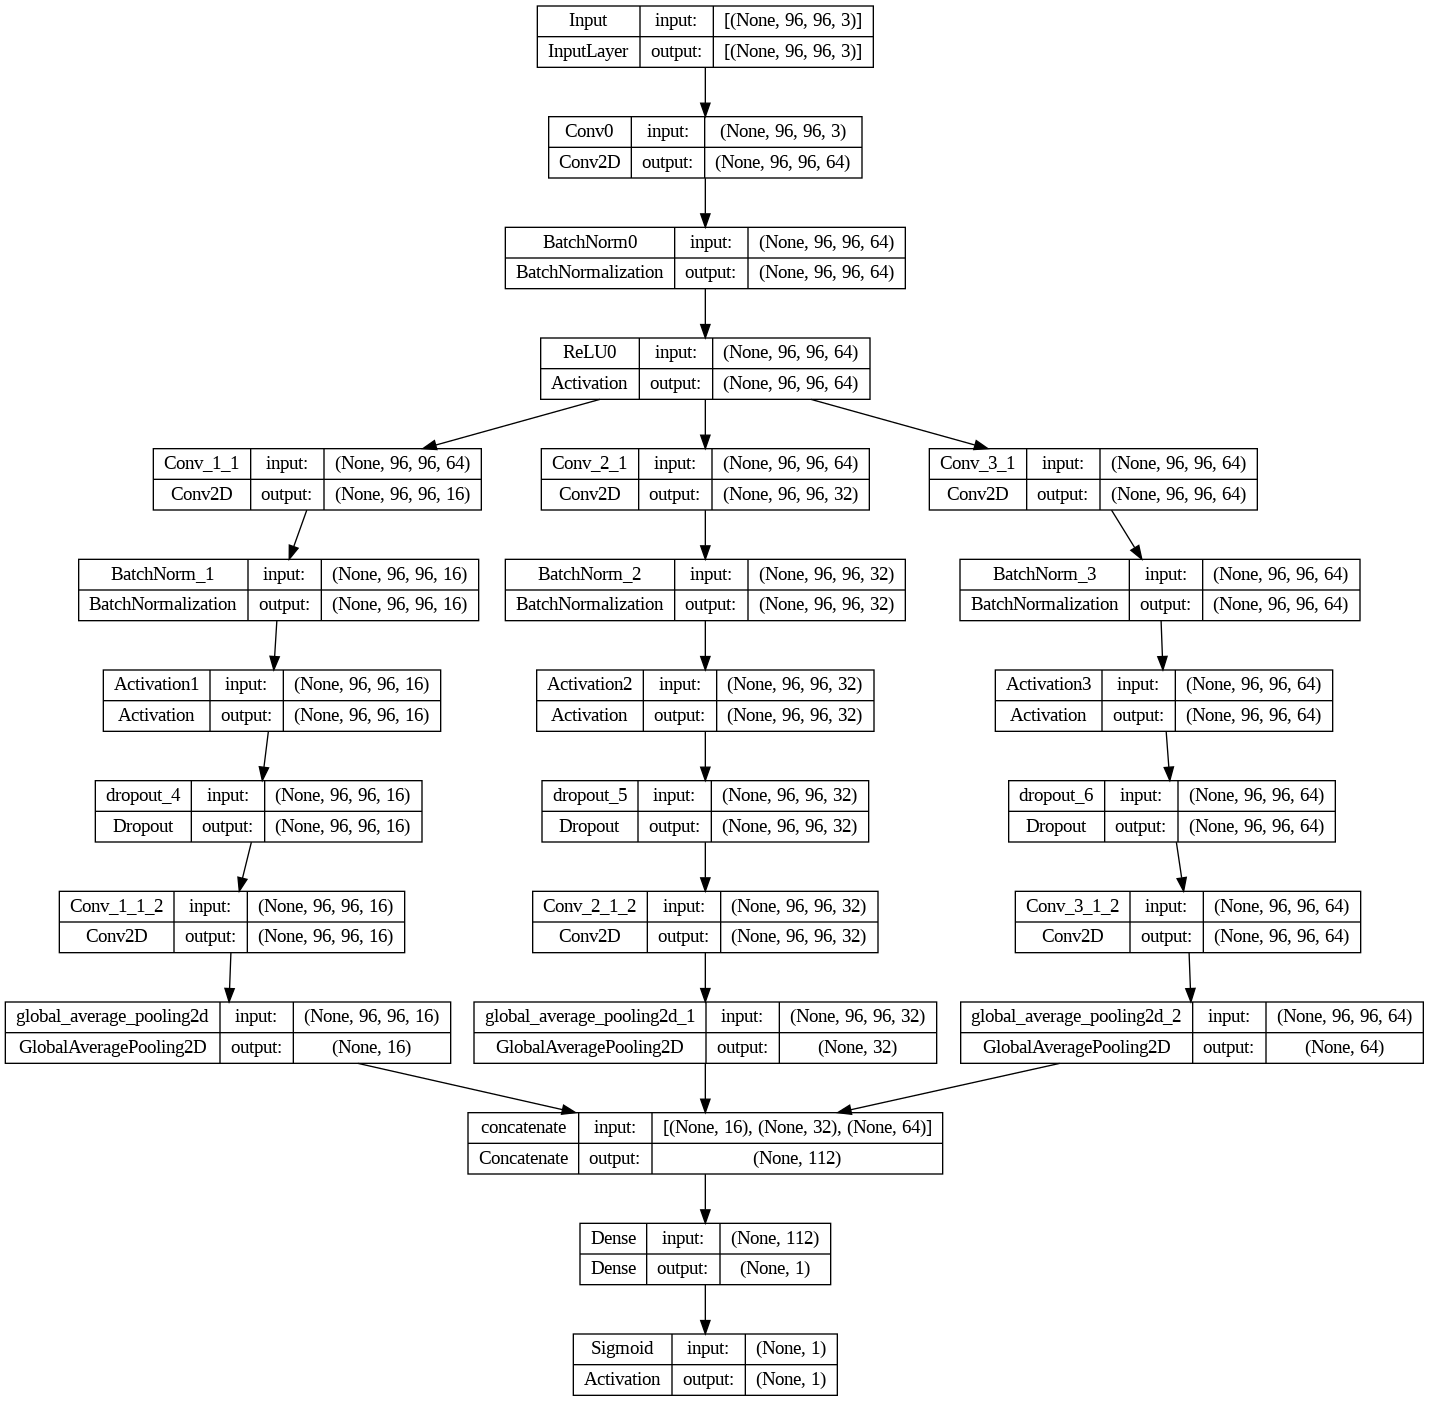

In [ ]:
parallel_CNN_model = build_Parallel_CNN()
parallel_CNN_model.summary()
tfk.utils.plot_model(parallel_CNN_model, expand_nested=True, show_shapes=True)

In [ ]:
parallel_history = parallel_CNN_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/100
 24/126 [====>.........................] - ETA: 23:55 - loss: 0.6721 - accuracy: 0.6042

KeyboardInterrupt: ignored

In [ ]:
# Plot validation loss for different models
plt.figure(figsize=(15, 3))
plt.plot(parallel_history['val_loss'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Plot validation accuracy for different models
plt.figure(figsize=(15, 3))
plt.plot(parallel_history['val_accuracy'], label='VGG18+BN+skip', alpha=0.8, color='#2ca02c')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Show the plots
plt.show()

In [ ]:
def conv_res_block(x,filters,kernel_size,padding = 'same', activation='relu',stack=1,name=''):

    x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    x_ = tfkl.Dropout(0.3, seed=seed)(x_)
    x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
def build_res_CNN(input_shape=input_shape,output_shape=output_shape, learning_rate=1e-4, seed=seed):

  tf.random.set_seed(seed)

  preprocessing = tfk.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomFlip("vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.3),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.4, value_range=(0,1)),
    tfkl.RandomContrast(0.6),
  ], name='Preprocessing')

  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Apply preprocessing to the input layer
  x0 = preprocessing(input_layer)

  x1 = conv_res_block(x0, filters=16, kernel_size=3, stack=2, name='1')
  x2 = conv_res_block(x1, filters=32, kernel_size=3, stack=2, name='2')
  x3 = conv_res_block(x2, filters=64, kernel_size=3, stack=2, name='3')
  x4 = conv_res_block(x3, filters=128, kernel_size=3, stack=2, name='4')

  # Global Average Pooling and classifier
  x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
  x = tfkl.Dense(output_shape, name='Dense')(x)
  output_activation = tfkl.Activation('sigmoid', name='Sigmoid')(x)

  # Create the model
  model = tfk.Model(inputs=input_layer, outputs=output_activation, name='res_CNN')
  optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
  loss = tfk.losses.BinaryCrossentropy()
  metrics = ['accuracy']

  # Compile the model
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

Model: "res_CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Preprocessing (Sequential)     (None, 96, 96, 3)    0           ['Input[0][0]']                  
                                                                                                  
 MaxPool_1 (MaxPooling2D)       (None, 48, 48, 3)    0           ['Preprocessing[0][0]']          
                                                                                                  
 Conv_11 (Conv2D)               (None, 48, 48, 16)   448         ['MaxPool_1[0][0]']              
                                                                                            

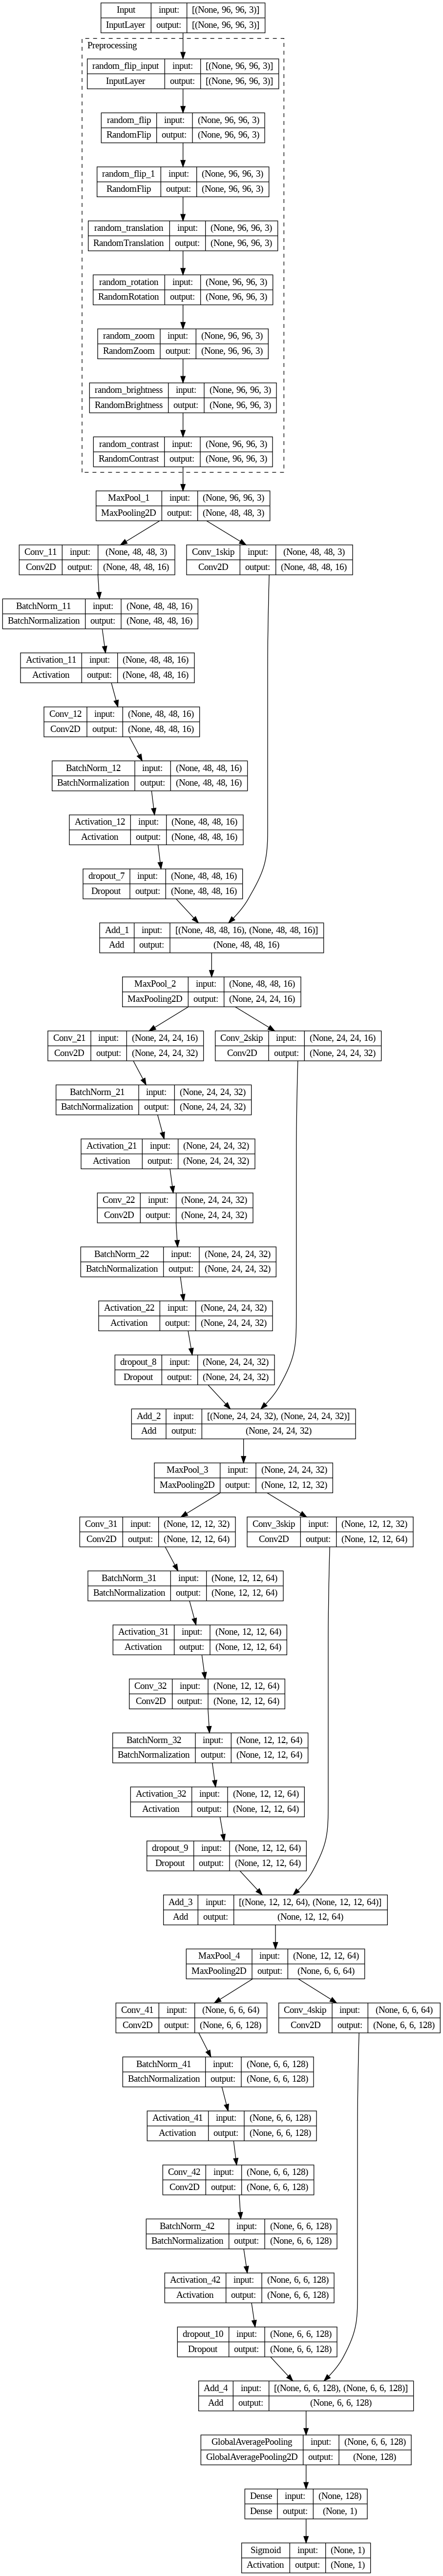

In [ ]:
res_model = build_res_CNN()
res_model.summary()
tfk.utils.plot_model(res_model, expand_nested=True, show_shapes=True)

In [ ]:
res_history = res_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/200
126/126 [==============================] - 78s 555ms/step - loss: 0.7214 - accuracy: 0.5997 - val_loss: 0.8778 - val_accuracy: 0.6208
Epoch 2/200
126/126 [==============================] - 70s 554ms/step - loss: 0.6459 - accuracy: 0.6299 - val_loss: 1.3741 - val_accuracy: 0.6208
Epoch 3/200
126/126 [==============================] - 71s 568ms/step - loss: 0.6412 - accuracy: 0.6382 - val_loss: 1.2755 - val_accuracy: 0.6208
Epoch 4/200
126/126 [==============================] - 70s 557ms/step - loss: 0.6330 - accuracy: 0.6452 - val_loss: 0.9928 - val_accuracy: 0.6208
Epoch 5/200
126/126 [==============================] - 69s 543ms/step - loss: 0.6292 - accuracy: 0.6462 - val_loss: 0.8344 - val_accuracy: 0.6267
Epoch 6/200
126/126 [==============================] - 72s 571ms/step - loss: 0.6236 - accuracy: 0.6562 - val_loss: 0.8200 - val_accuracy: 0.6208
Epoch 7/200
126/126 [==============================] - 72s 574ms/step - loss: 0.6158 - accuracy: 0.6679 - val_loss: 0.7120 -

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(res_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(res_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [11]:
def conv_resPar_block(x,filters,kernel_size,dense,padding = 'same', activation='relu',stack=1,name=''):

    x = tfkl.MaxPooling2D(name='MaxPool_' + dense + '_' + name)(x)

    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + dense + '_' + name + str(s+1))(x_)
        x_ = tfkl.BatchNormalization(name='BatchNorm_' + dense + '_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + dense + '_' + name + str(s+1))(x_)

    x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + dense + '_' + name + 'skip')(x)

    x = tfkl.Add(name='Add_' + dense + '_' + name)([x_, x])

    return x

In [15]:
def build_ParallelRes_CNN(input_shape=input_shape,output_shape=output_shape, learning_rate=1e-4, seed=seed):

  tf.random.set_seed(seed)

  preprocessing = tfk.Sequential([
    tfkl.RandomFlip("horizontal"),
    tfkl.RandomFlip("vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.3),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.4, value_range=(0,1)),
    tfkl.RandomContrast(0.6),
  ], name='Preprocessing')

  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Apply preprocessing to the input layer
  x0 = preprocessing(input_layer)

  # Initial convolution with batch normalization and activation
  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
  x = tfkl.BatchNormalization(name='BatchNorm0')(x)
  x = tfkl.Activation('relu', name='ReLU0')(x)

  parallelRes_CNN1 = conv_resPar_block(x,32,3,'par1',stack=2, name ='1')
  gap1 = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling1')(parallelRes_CNN1)
  parallelRes_CNN2 = conv_resPar_block(x,64,3,'par2', stack=2 ,name ='2')
  gap2 = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling2')(parallelRes_CNN2)
  parallelRes_CNN3 = conv_resPar_block(x,128,3,'par3', stack = 2,name ='3')
  gap3 = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling3')(parallelRes_CNN3)

  concatenated = tfkl.Concatenate()([gap1,gap2,gap3])
  x = tfkl.Dense(2, name='Dense')(concatenated)
  output_activation = tfkl.Activation('softmax', name='Sigmoid')(x)

  # Create the model
  model = tfk.Model(inputs=input_layer, outputs=output_activation, name='ParallelRes_CNN')
  optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
  loss = tfk.losses.CategoricalCrossentropy()
  metrics = ['accuracy']

  # Compile the model
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

Model: "ParallelRes_CNN"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Preprocessing (Sequential)  (None, 96, 96, 3)            0         ['Input[0][0]']               
                                                                                                  
 Conv0 (Conv2D)              (None, 96, 96, 64)           1792      ['Preprocessing[0][0]']       
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 96, 96, 64)           256       ['Conv0[0][0]']               
 tion)                                                                              

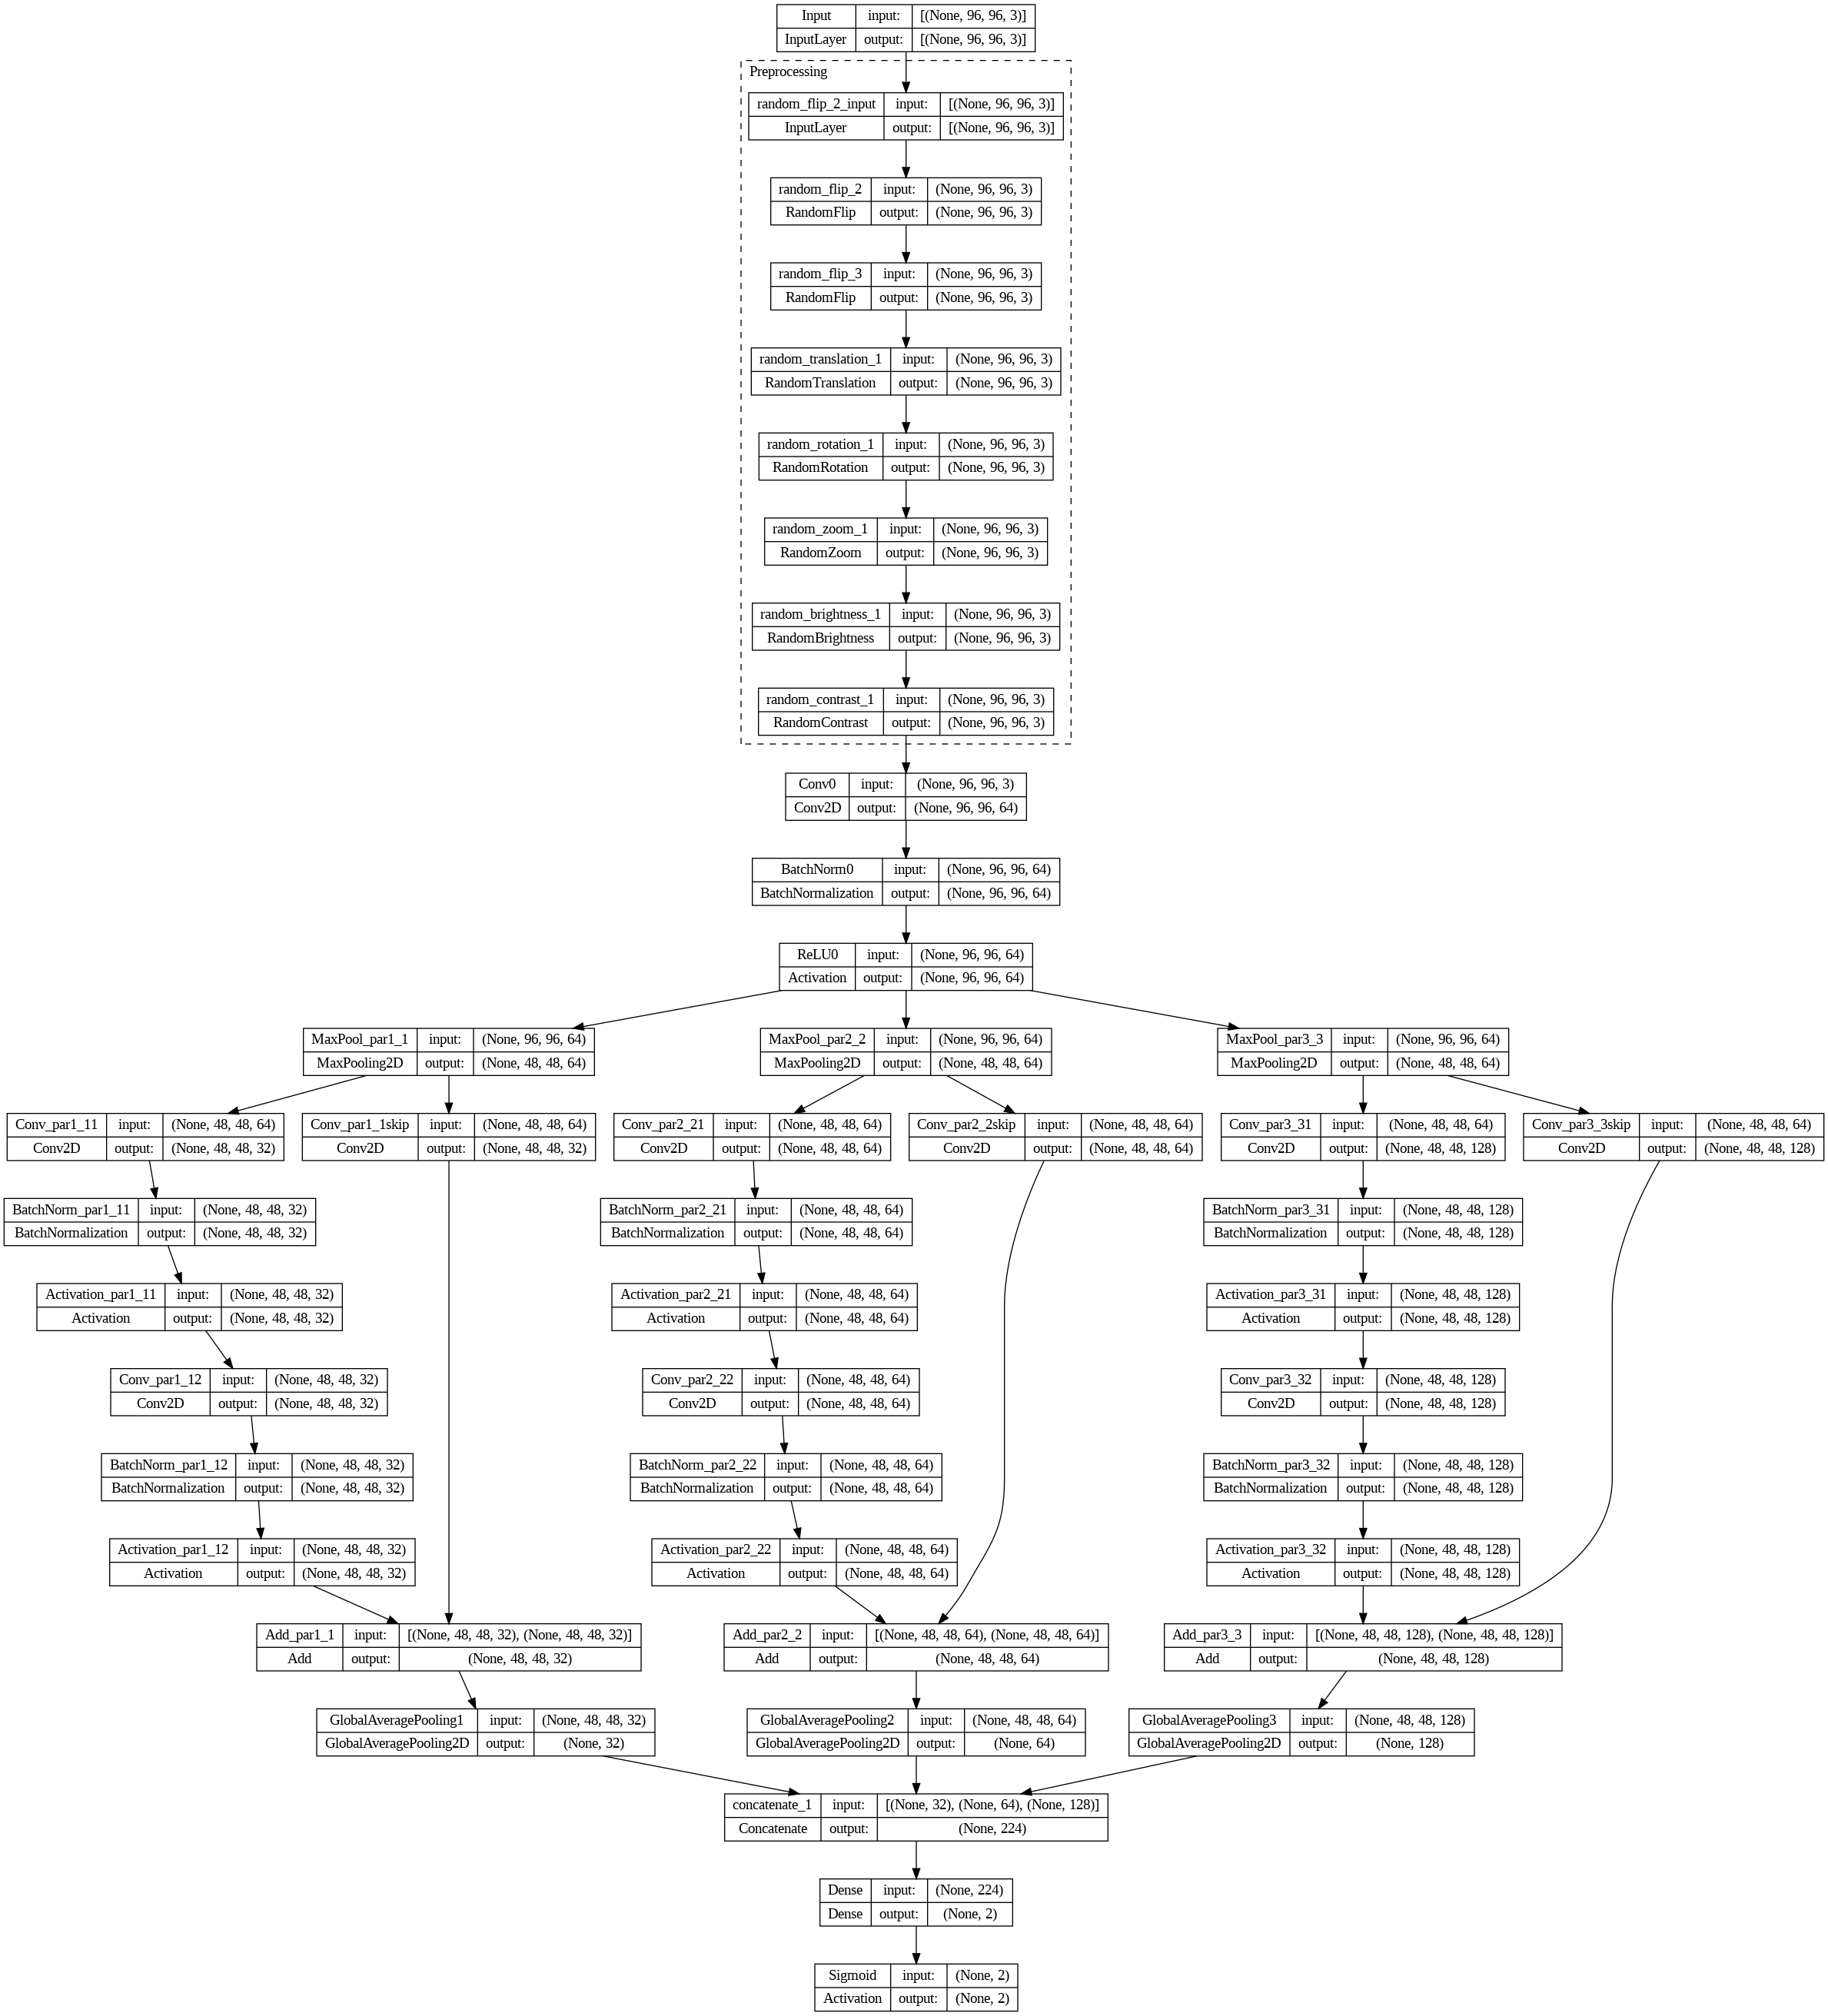

In [16]:
model = build_ParallelRes_CNN()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [17]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
).history

Epoch 1/200
126/126 [==============================] - 27s 82ms/step - loss: 0.6528 - accuracy: 0.6284 - val_loss: 0.7664 - val_accuracy: 0.6208
Epoch 2/200
126/126 [==============================] - 8s 67ms/step - loss: 0.6164 - accuracy: 0.6639 - val_loss: 1.1497 - val_accuracy: 0.6208
Epoch 3/200
126/126 [==============================] - 8s 65ms/step - loss: 0.5996 - accuracy: 0.6769 - val_loss: 1.0077 - val_accuracy: 0.6208
Epoch 4/200
126/126 [==============================] - 8s 67ms/step - loss: 0.6034 - accuracy: 0.6794 - val_loss: 0.6854 - val_accuracy: 0.6427
Epoch 5/200
126/126 [==============================] - 9s 69ms/step - loss: 0.5986 - accuracy: 0.6852 - val_loss: 0.5727 - val_accuracy: 0.6766
Epoch 6/200
126/126 [==============================] - 8s 66ms/step - loss: 0.5906 - accuracy: 0.6944 - val_loss: 0.5993 - val_accuracy: 0.6647
Epoch 7/200
126/126 [==============================] - 9s 68ms/step - loss: 0.5905 - accuracy: 0.6894 - val_loss: 0.5520 - val_accuracy

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%cd /gdrive/My Drive/ANN2DL/homework1/Alberto/models/ConvNext
model.save('Custom1_noOutliersAlbi')